In [1]:
import numpy as np
import math
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
from scipy.special import expit
import matplotlib.pyplot as plt
from random import randint


In [2]:
# Load and configure data
wine_data = load_wine()
# The data matrix (178,)
data = np.asarray(wine_data.data)
# The classification matrix (178,13)
target = np.asarray(wine_data.target)

# choose the first 130 to make it a binary problem
# Since the original data is organized -> simply choose first 130 elem)
X = data[0:130]
Y = target[0:130]
# preprocessing fix to avoid convergencewarning
X = StandardScaler().fit_transform(X)
# Append b to the list
X = np.asarray(np.hstack((X, np.ones((len(X),1)))))
# modify Y to use -1 and 1 labels
# Y = np.where(Y == 0, -1, Y)
print(X)
print(Y)

[[ 1.452455   -0.29441432  0.30247764 ...  2.04002469  0.782868
   1.        ]
 [ 0.28906609 -0.21455828 -0.67719651 ...  0.94143735  0.74015178
   1.        ]
 [ 0.24388594  0.4471061   1.11324246 ...  0.45552372  1.12459784
   1.        ]
 ...
 [-1.30353427  0.18472195  1.484843   ... -1.0867239  -0.92293343
   1.        ]
 [-0.64842207 -0.38567837 -0.13668663 ... -0.36841679 -1.27605426
   1.        ]
 [-1.02115832  2.66025935  0.13356831 ... -0.81207706 -0.59829008
   1.        ]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Standard logistic regression solver

In [20]:
def loss_s(X, y, w):
    loss = 0;
    for i in range(len(X)):
        dot = np.dot(w, X[i]);
        assert dot.shape[0] ==1
        loss += np.log(1 + np.exp(-y[i]* dot))
    return loss

# Standard logistic regression https://stackoverflow.com/questions/25427650/sklearn-logisticregression-without-regularization
# penalty = 'none' means no regularlation
lr = LogisticRegression(random_state=1, C=math.pow(10, 5),max_iter=10000, solver='sag')
lr.fit(X,Y)
w = lr.coef_
print("w:", w)
L_star = loss_s(X, Y, w)
#print("L* = ", L_star)
L_star = log_loss(Y, lr.predict_proba(X))
print("L* = ", L_star)

w: [[-5.65567085 -2.04749007 -4.36012073  5.49155832 -0.72937152  0.08800773
  -1.54767875  0.65781456  0.64179689 -2.00784809  0.46035315 -2.46101695
  -7.43793772  0.01431959]]
L* =  0.00022533393014774908


## Coordinate Descent 

In [21]:
# helper functions
from tqdm import tqdm
from sklearn.metrics import accuracy_score
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cross_entropy_loss(y,y_pred):
    #a = -(1/len(y))*np.sum(y*np.log(y_pred) + (1 - y)*np.log(1 - y_pred))
    a = -(1/len(y))
    b = y*np.log(y_pred)
    c = (1-y)*np.log(1-y_pred)
    d = a*np.sum(b+c)
    return d

def cross_entropy_grad(y,y_pred,x):
    return list(np.dot((y_pred - y),X)[0])
    
#def loss_prime(X,Y,w):
#    loss = 0;
#    for i in range(len(X)):
#        #print("x:",X[i], "\ny:", Y[i], "\nw:",w)
#        denominator = 1 + np.exp(Y[i] * np.dot(w, X[i].reshape(14,1)))
#        #print(np.exp(Y[i]*np.dot(w, X[i])))
#        loss_i = (-Y[i]*X[i])/(denominator)
#        loss += loss_i
#    return loss;

# initial weights
w = np.zeros(14).reshape(14,1)
w_rand = w

print(w.shape, X.shape, Y.shape)

eta = 0.01
loss = []
loss_rand = []
num_iter = 100000 # just take a bunch of iterations
for t in tqdm(range(num_iter)):
    
    # predict step 
    y_pred = sigmoid(np.dot(w.T,X.T))
    grad = cross_entropy_grad(Y,y_pred,X)
    
    largest = np.argmax(np.abs(grad)) # idx with largest magnitude
    loss.append(cross_entropy_loss(Y,y_pred))  
    
    # update that coordinate with largest gradient in magnitude
    w[largest] = w[largest] - eta*grad[largest]

y_pred = sigmoid(np.dot(w.T,X.T))
y_pred = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, y_pred.flatten()))) # post processing

print("Accuracy for best coordinate descent {0}".format(accuracy_score(Y, y_pred)))
print("Loss L = {0}".format(loss[-1]))

(14, 1) (130, 14) (130,)


100%|██████████| 100000/100000 [00:04<00:00, 23917.57it/s]

Accuracy for best coordinate descent 1.0
Loss L = 0.00019283109799850333


In [22]:
#Random Index
# initial weights
w = np.zeros(14).reshape(14,1)
w_rand = w

eta = 0.01
loss_rand = []
num_iter = 100000
for t in tqdm(range(num_iter)):
    
    # predict step
    y_pred = sigmoid(np.dot(w.T,X.T))
    loss_rand.append(cross_entropy_loss(Y,y_pred))  
    grad = cross_entropy_grad(Y,y_pred,X)
    random = randint(0,13)
    
    # update random coordinate
    w_rand[random] = w_rand[random] - eta*grad[random]
    
y_pred = sigmoid(np.dot(w_rand.T,X.T))
y_pred = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, y_pred.flatten())))

print("Accuracy for random coordinate descent {0}".format(accuracy_score(Y, y_pred)))
print("Loss L = {0}".format(loss_rand[-1]))

100%|██████████| 100000/100000 [00:03<00:00, 26902.95it/s]

Accuracy for random coordinate descent 1.0
Loss L = 0.00042463922828810645


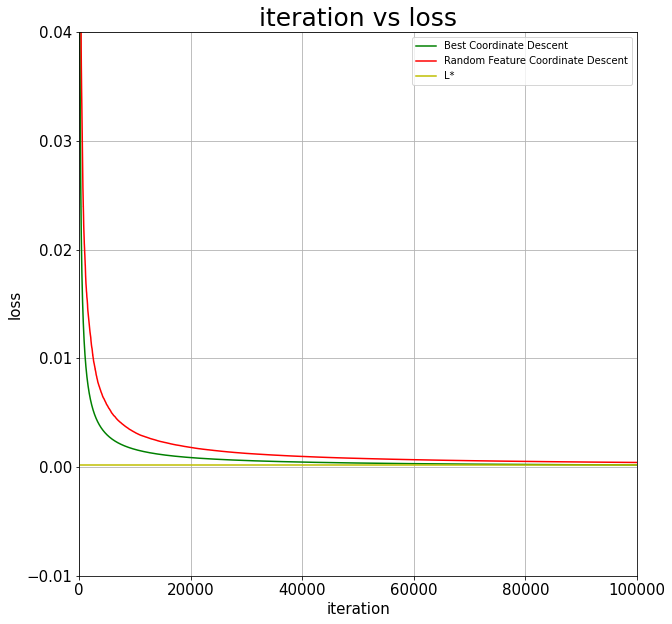

In [26]:
#Plot
plt.figure(figsize=(10,10))
plt.plot(loss, 'g-', label='Best Coordinate Descent') # loss best coordinate descent
plt.plot(loss_rand, 'r-', label='Random Feature Coordinate Descent')
plt.axhline(y=L_star, color='y', label='L*')
plt.title('iteration vs loss', fontsize=25)
plt.xlabel('iteration', fontsize=15)
plt.xlim(0,100000)
plt.ylim((-0.01,0.04))
plt.ylabel('loss', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend()